# **UNSW-NB15 NETWORK INTRUSION**

## **Importing Libraries**

In [81]:
import numpy as np
import tensorflow as tf;
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree  import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score,f1_score, roc_curve, roc_auc_score;
from sklearn.ensemble import RandomForestClassifier;
from sklearn.feature_selection import RFE
import itertools
from xgboost import XGBClassifier
from tabulate import tabulate


## **Importing Testing and Training Dataset**

In [82]:
train=pd.read_csv('UNSW_NB15_training-set.csv')

In [83]:
test=pd.read_csv('UNSW_NB15_testing-set.csv')

In [84]:
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,Normal,0


In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [86]:
train.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,8.233200e+04,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,82332.000000,82332.00000,8.233200e+04,8.233200e+04,82332.00000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,41166.500000,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,6.305470e+05,4.753692,6.308556,755.394301,121.701284,6.363075e+03,535.180430,133.45908,1.084642e+09,1.073465e+09,128.28662,0.055925,0.029256,0.026669,139.528604,116.275069,0.094277,1.595372e+03,9.546604,1.369273,5.744923,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,23767.345519,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,2.393001e+06,64.649620,55.708021,6182.615732,1292.378499,5.672402e+04,3635.305383,127.35700,1.390860e+09,1.381996e+09,127.49137,0.116022,0.070854,0.055094,208.472063,244.600271,0.542922,3.806697e+04,11.090289,1.067188,8.418112,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.00000,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20583.750000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.00000,0.000000e+00,0.000000e+00,0.00000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,41166.500000,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,2.112951e+03,1.000000,0.000000,0.557929,0.010000,1.762392e+01,0.000000,255.00000,2.788886e+07,2.856975e+07,255.00000,0.000551,0.000441,0.000080,65.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,61749.250000,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,1.585808e+04,3.000000,2.000000,63.409444,63.136369,3.219332e+03,128.459914,255.00000,2.171310e+09,2.144205e+09,255.00000,0.105541,0.052596,0.048816,100.000000,87.000000,0.000000,0.000000e+00,11.000000,2.000000,6.000000,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,82332.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,2.082111e+07,5319.000000,5507.000000,60009.992000,57739.240000,1.483831e+06,463199.240100,255.00000,4.294950e+09,4.294881e+09,255.00000,3.821465,3.226788,2.928778,1504.000000,1500.000000,131.000000,5.242880e+06,63.000000,6.000000,59.000000,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000,1.000000


In [87]:
train.describe(include='object')

,proto,service,state,attack_cat
count,82332,82332,82332,82332
unique,131,13,7,10
top,tcp,-,FIN,Normal
freq,43095,47153,39339,37000


In [88]:
train.shape

(82332, 45)

In [89]:
train.isnull().sum()

,0
id,0
dur,0
proto,0
service,0
state,0
spkts,0
dpkts,0
sbytes,0
dbytes,0
rate,0


In [90]:
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 0


## **Attack Classes**

<Axes: xlabel='attack_cat', ylabel='count'>

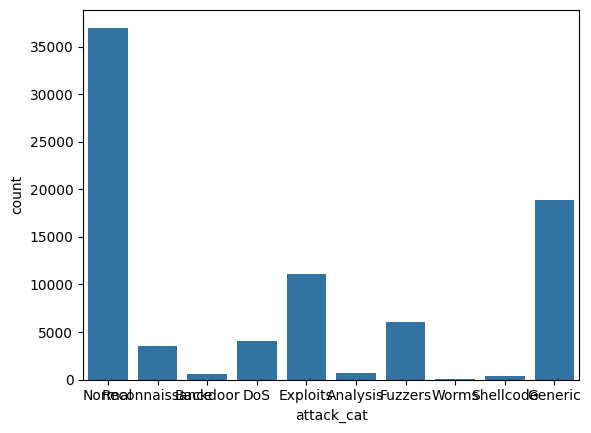

In [91]:
sns.countplot(x=train['attack_cat'])

In [92]:
print("Attack class Distribution:-");
print(train['attack_cat'].value_counts())

Attack class Distribution:-
attack_cat
Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

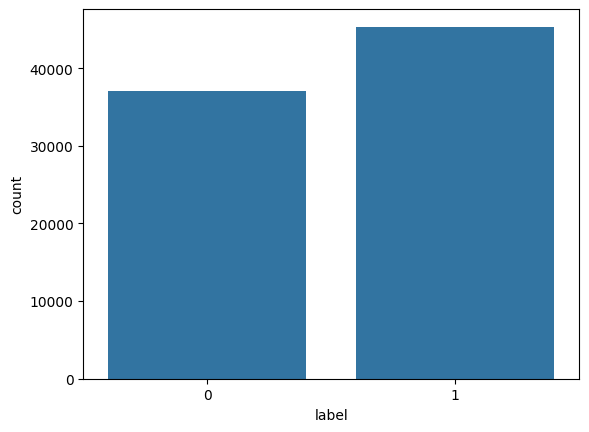

In [93]:
sns.countplot(x=train['label'])

In [94]:
print('Class distribution Training set:')
print(train['label'].value_counts())

Class distribution Training set:
label
1    45332
0    37000
Name: count, dtype: int64


## **Data Pre-Processing**

In [95]:
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

le(train)
le(test)

In [96]:
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,117,0,4,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,6,0
1,2,0.000008,117,0,4,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,6,0
2,3,0.000005,117,0,4,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,6,0
3,4,0.000006,117,0,4,2,0,900,0,166666.6608,254,0,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,6,0
4,5,0.000010,117,0,4,2,0,2126,0,100000.0025,254,0,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,6,0


In [97]:
X_train = train.drop(['label'], axis=1)
Y_train = train['label']

In [98]:
X_test=test.drop(['label'],axis=1)
Y_test=test['label']

### **Feature Selection**

In [99]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['id',
 'sbytes',
 'dbytes',
 'rate',
 'sttl',
 'sload',
 'ct_state_ttl',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'attack_cat']

In [100]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

### **Feature Scaling**

In [101]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.fit_transform(X_test)

In [102]:
#x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train,X_test, train_size=0.70, random_state=2)

In [103]:
print(X_train)
print(Y_train)


[[-1.73202977 -0.04368361 -0.08736871 ... -0.45018649 -0.47799398
   0.70710473]
 [-1.7319877  -0.03630776 -0.08736871 ... -0.45018649 -0.47799398
   0.70710473]
 [-1.73194562 -0.04035108 -0.08736871 ... -0.45018649 -0.39039089
   0.70710473]
 ...
 [ 1.73194562 -0.04630536 -0.08736871 ... -0.45018649 -0.56559707
   0.70710473]
 [ 1.7319877  -0.04630536 -0.08736871 ... -0.45018649 -0.56559707
   0.70710473]
 [ 1.73202977 -0.04596744 -0.08736871 ... -0.45018649 -0.56559707
   0.70710473]]
0        0
1        0
2        0
3        0
4        0
        ..
82327    0
82328    0
82329    0
82330    0
82331    0
Name: label, Length: 82332, dtype: int64


## **Decision Tree**

In [104]:
Decision_classifier=DecisionTreeClassifier(criterion='entropy')
Decision_classifier.fit(X_train,Y_train)

Decision_pred=Decision_classifier.predict(X_test)
print(Decision_pred)

[0 0 0 ... 1 1 1]


### **R2_Score**

In [105]:
from sklearn.metrics import r2_score;
r2_score(Y_test,Decision_pred)


1.0

### **Accuracy Score**

In [106]:
Decision_Accuracy=accuracy_score(Decision_pred,Y_test)
print(Decision_Accuracy)

1.0


### **Precision Score**

In [107]:
Decision_precision=precision_score(Y_test,Decision_pred)
print(Decision_precision)

1.0


### **Confusion Matrics**

In [108]:
D_matrix=confusion_matrix(Y_test,Decision_pred)
print(D_matrix)

[[ 56000      0]
 [     0 119341]]


## **Random Forest**

In [109]:
Random_classifier=RandomForestClassifier(n_estimators=100)
Random_classifier.fit(X_train,Y_train)

Random_pred=Random_classifier.predict(X_test)
print(Random_pred)

[0 0 0 ... 1 1 1]


### **R2_Score**

In [110]:
r2_score(Y_test,Random_pred)

0.9661286878117568

### **Accuracy_Score**

In [111]:
Random_Accuracy=accuracy_score(Random_pred,Y_test)
print(Random_Accuracy)

0.9926372040766278


### **Precision**

In [112]:
Random_precision=precision_score(Y_test,Random_pred)
print(Random_precision)

1.0


### **Confusion Matrics**

In [113]:
R_matrix=confusion_matrix(Y_test,Random_pred)
print(R_matrix)

[[ 56000      0]
 [  1291 118050]]


## **Artificial Neural Networks**

### **Model Creation and Compilation**

In [114]:
ANN=tf.keras.models.Sequential()

In [115]:
ANN.add(tf.keras.layers.Dense(units=6,activation='relu'))
ANN.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

ANN.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy']);


### **Training and Testing**

In [116]:
ANN.fit(X_train,Y_train,batch_size=32,epochs=100)

Epoch 1/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8913 - loss: 0.3027
Epoch 2/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9706 - loss: 0.0679
Epoch 3/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9947 - loss: 0.0231
Epoch 4/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9994 - loss: 0.0071
Epoch 5/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9999 - loss: 0.0023
Epoch 6/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 1.0000 - loss: 9.4019e-04
Epoch 7/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 1.0000 - loss: 3.7246e-04
Epoch 8/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 1.4165e-04
Epoch 9/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 1.0000 - loss: 5.5835e-05
Epoch 10/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 1.0000 - loss: 2.5841e-05
Epoch 11/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 1.4798

In [117]:
ANN_pred=ANN.predict(X_test);
ANN_pred=(ANN_pred>0.5);

5480/5480 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


### **Accuracy And Precision Scores**

In [118]:
print("Acuracy Score:-")
ANN_Accuracy=accuracy_score(ANN_pred,Y_test)
print(ANN_Accuracy)
print("\n\nPrecision Score")
ANN_precision=precision_score(Y_test,ANN_pred)
print(ANN_precision)

Acuracy Score:-
0.9989677257458324


Precision Score
0.9984939759036144


## **ROC_CURVE**

In [119]:
fpr_dt,tpr_dt,_=roc_curve(Y_test,Decision_pred)
fpr_rf,tpr_rf,_=roc_curve(Y_test,Random_pred)
fpr_ann,tpr_ann,_=roc_curve(Y_test,ANN_pred)

In [120]:
auc_dt=roc_auc_score(Y_test,Decision_pred)
auc_rf=roc_auc_score(Y_test,Random_pred)
auc_ann=roc_auc_score(Y_test,ANN_pred)

In [121]:
print(auc_dt)
print(auc_rf)
print(auc_ann);

1.0
0.994591129620164
0.9983886674678921


In [127]:
print(fpr_dt)
print(fpr_rf)
print(fpr_ann);

[0. 0. 1.]
[0. 0. 1.]
[0.         0.00321429 1.        ]


## **F1-Scores**

In [123]:
Decision_f1=f1_score(Y_test,Decision_pred)
Random_f1=f1_score(Y_test,Random_pred)
ANN_f1=f1_score(Y_test,ANN_pred)

## **Tabuler View of Model Scores**

In [124]:
data = [["Random Forest", Random_Accuracy,Random_precision,fpr_rf,Random_f1],
        ["Artificial Neural Networks", ANN_Accuracy,ANN_precision,fpr_ann,ANN_f1],
        ["Decision Tree", Decision_Accuracy, Decision_precision,fpr_dt,Decision_f1]]

col_names = ["Model", "Accuracy Score","Model precision","FPR","F1-Score"];
print("\bAccuracy of the the 3 test modles with train and test data are:-\b");
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

Accuracy of the the 3 test modles with train and test data are:-
╒════════════════════════════╤══════════════════╤═══════════════════╤════════════════════════════════════╤════════════╕
│ Model                      │   Accuracy Score │   Model precision │ FPR                                │   F1-Score │
╞════════════════════════════╪══════════════════╪═══════════════════╪════════════════════════════════════╪════════════╡
│ Random Forest              │         0.992637 │          1        │ [0. 0. 1.]                         │   0.994562 │
├────────────────────────────┼──────────────────┼───────────────────┼────────────────────────────────────┼────────────┤
│ Artificial Neural Networks │         0.998968 │          0.998494 │ [0.         0.00321429 1.        ] │   0.999242 │
├────────────────────────────┼──────────────────┼───────────────────┼────────────────────────────────────┼────────────┤
│ Decision Tree              │         1        │          1        │ [0. 0. 1.]             

## **Plotting of Scores**

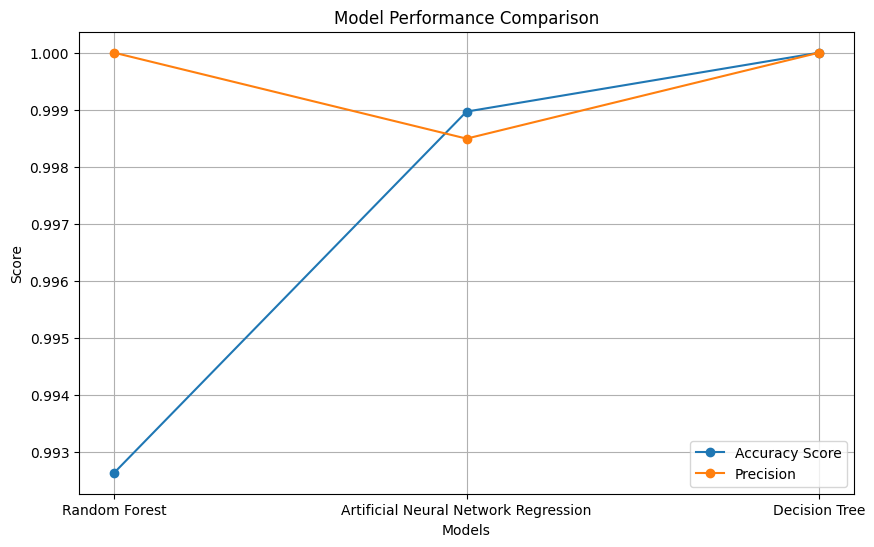

In [125]:
models = ["Random Forest", "Artificial Neural Network Regression", "Decision Tree"]
Accuracy_scores = [Random_Accuracy,ANN_Accuracy, Decision_Accuracy]
precision_scores = [Random_precision, ANN_precision, Decision_precision]


x = range(len(models))

plt.figure(figsize=(10, 6))
plt.plot(x, Accuracy_scores, label='Accuracy Score', marker='o')
plt.plot(x, precision_scores, label='Precision', marker='o')

plt.xticks(x, models)
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(True)
plt.show()


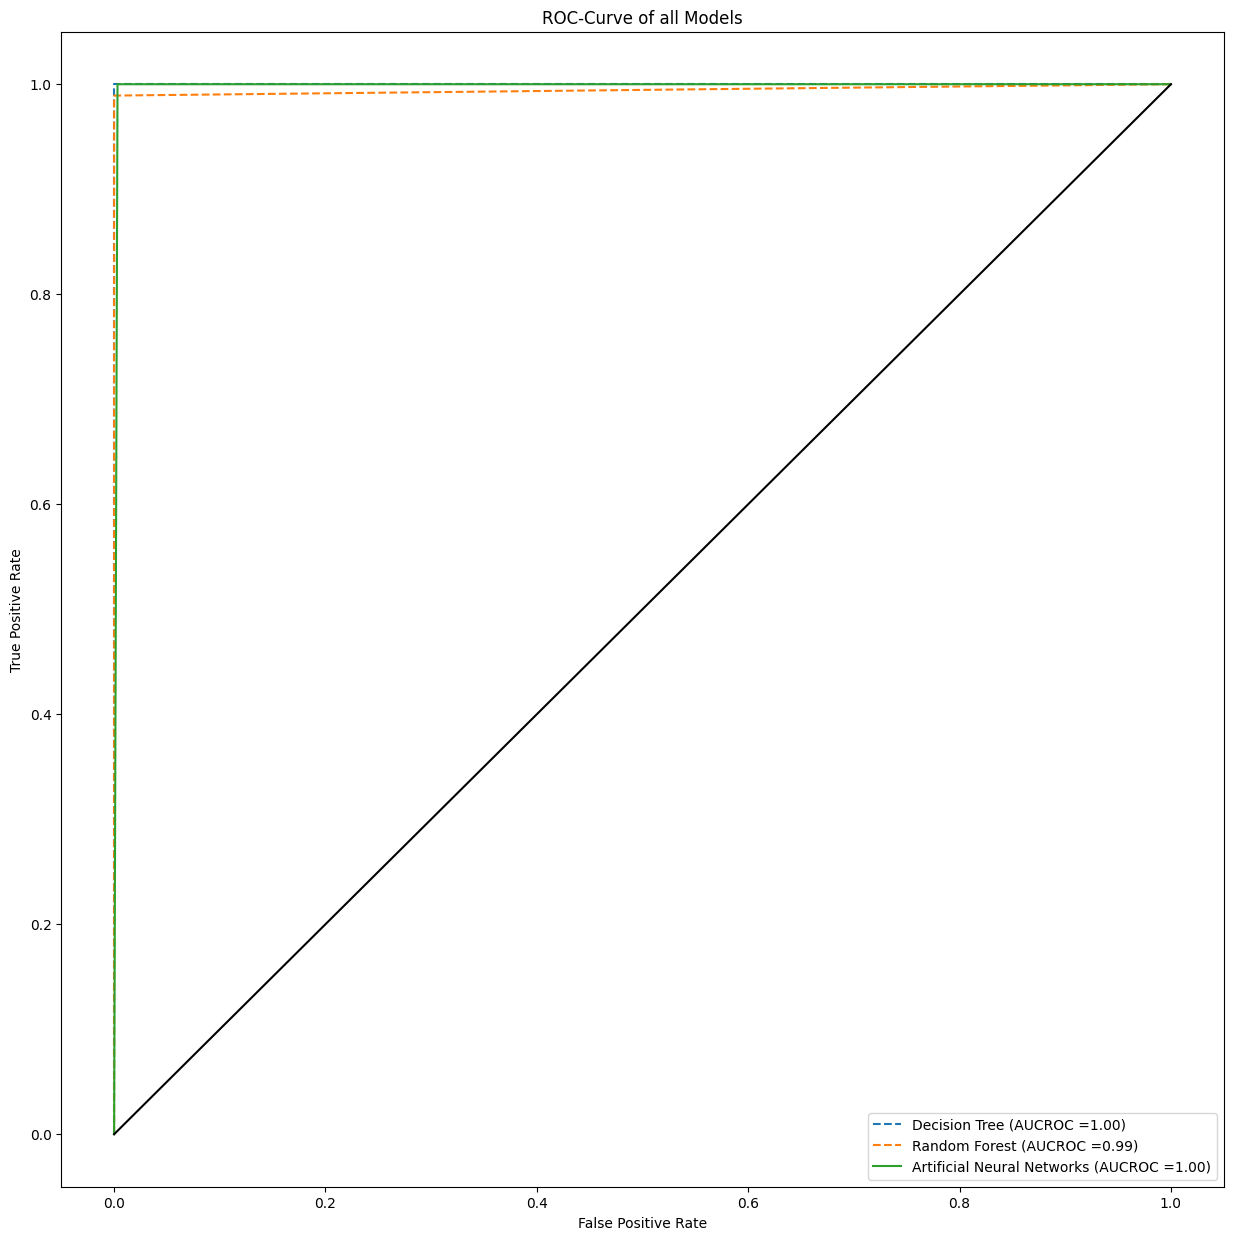

In [154]:
plt.figure(figsize=(15,15))
plt.plot(fpr_dt, tpr_dt,linestyle="--",label=f'Decision Tree (AUCROC =%0.2f)'%auc_dt)
plt.plot(fpr_rf, tpr_rf,linestyle="--", label=f'Random Forest (AUCROC =%0.2f)'%auc_rf)
plt.plot(fpr_ann, tpr_ann ,label=f'Artificial Neural Networks (AUCROC =%0.2f)'%auc_ann)
plt.plot([0,1],color="black")  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Curve of all Models')
plt.legend()
plt.show()
